<a href="https://colab.research.google.com/github/poojan007/ICT619-Waste-Sorting-Assistant/blob/main/ICT619_Assignment_1_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SmartSort Model
This model provides outlines a process for loading augmenting, and training a convolutional neural network (CNN) on image data for a binary classification task.



## Upload file by mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/mntDrive')

Mounted at /mntDrive


In [4]:
# load data from google drive and unzip it

!unzip -q /mntDrive/MyDrive/ICT619-Dataset/archive.zip -d data

## Importing Libraries

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

## Define dataset paths

In [6]:
train_dir = '/content/data/DATASET/TRAIN'
validation_dir = '/content/data/DATASET/TEST'

## Data Augmentation

A data augmentation pipeline is created using a 'Sequential' model, which includes random flips, rotations, zooms, and translations. This is to artifically expland the training dataset by generating modifiied versions of the training images, helping the model generalize better.

In [7]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)
])


## Loading the datasets

The training and validation datasets are loaded from directories, specifying image size, batch size, and how the data is split. The 'validation_split' parameter

In [8]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 22564 files belonging to 2 classes.
Using 18052 files for training.
Found 2513 files belonging to 2 classes.
Using 502 files for validation.


## Configuring Datasets for Performance

These lines configure the datasets for performance '.cache()' keeps the images in memory after they're loaded off disk during the first epoch, '.shuffle()' randamizes the order of the images to reduce model overfitting, and '.prefetch()' overlaps data preprocessing and model execution while training.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building

Building the CNN model architecture. It starts with the data augmentation layer, followed by a rescaling layer to normalize pixel values. Then, it adds convolutional and max pooling layers for feature extraction, followed by dense layers for classification. The final layer uses a sigmoid activation function suitable for binary classification.

In [10]:
model = models.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


## Compile the Model

The model is compiled with the Adam optimizer and binary crossentropy loss function, which is appropriate for binary classification tasks. The model's performance will be evaluated based on accuracy.

In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Model Training

Finally, the model is trained for a defined number of epochs using the training dataset, with validation performed on the validation dataset. The 'fit' method returns a history object containing training and validation loss and accuracy for each epoch, which can be used for analysis of the model's performance over time.

In [12]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
565/565 [==============================] - 950s 2s/step - loss: 0.6780 - accuracy: 0.7816 - val_loss: 0.3716 - val_accuracy: 0.8645
Epoch 2/10
565/565 [==============================] - 900s 2s/step - loss: 0.4450 - accuracy: 0.8048 - val_loss: 0.3531 - val_accuracy: 0.8685
Epoch 3/10
565/565 [==============================] - 904s 2s/step - loss: 0.4407 - accuracy: 0.8050 - val_loss: 0.3249 - val_accuracy: 0.8845
Epoch 4/10
565/565 [==============================] - 910s 2s/step - loss: 0.4392 - accuracy: 0.8069 - val_loss: 0.2910 - val_accuracy: 0.8944
Epoch 5/10
565/565 [==============================] - 902s 2s/step - loss: 0.4276 - accuracy: 0.8140 - val_loss: 0.3580 - val_accuracy: 0.8924
Epoch 6/10
565/565 [==============================] - 899s 2s/step - loss: 0.4286 - accuracy: 0.8047 - val_loss: 0.3312 - val_accuracy: 0.9044
Epoch 7/10
565/565 [==============================] - 925s 2s/step - loss: 0.4212 - accuracy: 0.8177 - val_loss: 0.3131 - val_accuracy: 0.9084

## Evaluating the performance

In [13]:
loss, accuracy = model.evaluate(train_ds, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(val_ds, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8251
Testing Accuracy:  0.9064


## Visualizing training results

The plots of loss and accuracy on the training and validation sets.

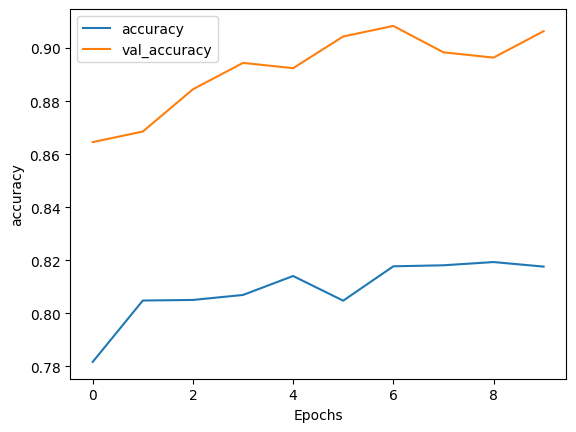

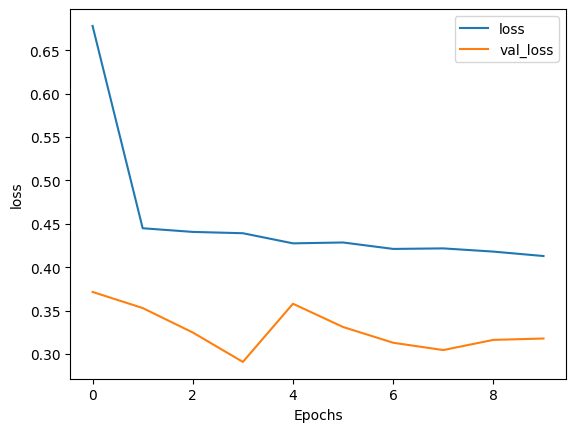

In [17]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Validating the model

In [37]:
# Function to prepare and predict the class of an image
def predict_with_augmentation(img_path, model):
    # Load the image
    img = image.load_img(img_path, target_size=(img_height, img_width))

    # Convert the image to a numpy array
    img_array = image.img_to_array(img)

    # Expand dimensions to match the shape of model input
    img_array = np.expand_dims(img_array, axis=0)

    # Predict (data augmentation is applied automatically)
    prediction = model.predict(img_array)

    print(prediction)

    if prediction[0][0] > 0.5:
      predicted_class = 'Recyclable Waste'
    else:
      predicted_class = 'Organic Waste'

    return predicted_class

In [38]:
# Example usage
img_path = '/organic-waste-23505461.jpg'
predicted_class = predict_with_augmentation(img_path, model)
print(f'Predicted: {predicted_class}')

1/1 [==============================] - 0s 40ms/step
[[0.82512325]]
Predicted: Recyclable Waste
